# imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import linalg
import scipy.stats as sts 
from matplotlib.gridspec import GridSpec
import seaborn as sns
import warnings
import matplotlib.cbook
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
from joblib import Parallel, delayed  
import multiprocessing
num_cores = multiprocessing.cpu_count()
from tqdm import tqdm
from scikits import bootstrap
plt.rcParams.update({'font.size': 10})
sns.set_context("talk", font_scale=0.9)
sns.set_style({"ytick.direction": "in"})
sns.set_style({"xtick.direction": "in"})


In [2]:

df_A1 = pd.read_csv("Data/RW_dataframe_A1_nozscore_smooth.csv")
df_PFC = pd.read_csv("Data/RW_dataframe_PFC_nozscore_smooth.csv")

stim_to_stim = df_A1.groupby(["stims","IA","IB","context","decision"]).mean().reset_index()[["stims","IA","IB","context","decision"]].values

time = np.loadtxt("Data/time.txt")
stim_idx = (time>=0) & (time<=0.25)

with open("Data/decoders/all_pseudo_projs_A1.pickle","rb") as f:
    all_projs=pickle.load(f)

with open("Data/decoders/all_pseudo_projs_A1_random.pickle","rb") as f:
    all_projs_shuf=pickle.load(f)

map_stims = {s[0]: s[1:] for s in stim_to_stim}

lc_idx = [0,2,4,6]
pc_idx = [1,3,5,7]

go_lc = np.array([True,True,False,False])
go_pc = np.array([False,True,False,True])
gos = [go_lc,go_pc]


go_mod = np.zeros([3,2,400,40])
go_mod_shuf = np.zeros([3,2,400,40])


0.03749999999999998 0.155
0.004166666666666652 0.04416666666666667


Text(0, 0.5, 'probability')

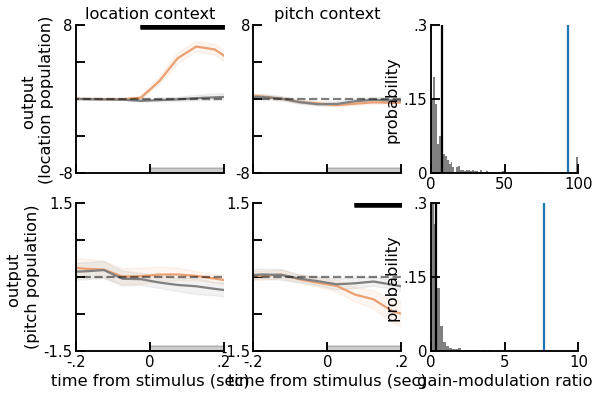

In [3]:

fig = plt.figure(figsize=(9,6))

titles = ["location context","pitch context"]

for i,idx in enumerate([lc_idx,pc_idx]):

    # pop 1
    plt.subplot(2,3,i+1)
    plt.title(titles[i])
    projs = all_projs[1][:,idx]
    go_proj = np.mean(projs[:,gos[i],:],1)
    nogo_proj = np.mean(projs[:,~gos[i],:],1)

    stderr = np.array([np.percentile(go_proj[:,t],[16,100-16]) for t in range(len(time))])
    plt.fill_between(time,stderr[:,0],stderr[:,1],alpha=0.1,color='#eba071')
    plt.plot(time,np.mean(go_proj,0),color='#eba071',label="relevant")

    stderr = np.array([np.percentile(nogo_proj[:,t],[16,100-16]) for t in range(len(time))])
    plt.fill_between(time,stderr[:,0],stderr[:,1],alpha=0.1,color="gray")
    plt.plot(time,np.mean(nogo_proj,0),color="gray",label="irrelevant")
    
    if i==0: plt.ylabel('output \n(location population)')
    plt.ylim(-6,6)
    plt.yticks([-8,-4,0,4,8],["-8","","","","8"])
    plt.plot(time,np.zeros_like(time),"k--",alpha=0.5)
    plt.xlim(-0.2,0.2)
    plt.xticks([-.2,0,.2],[])
    ymin,ymax = plt.ylim()
    plt.fill_between([0,.25],[ymin+0.6,ymin+0.6],[ymin,ymin],color="black",alpha=0.2)
    #plt.legend()

    sigs = np.array([np.mean(np.mean(go_proj[:,t]) > nogo_proj[:,t])  for t in range(len(time))])
    plt.fill_between(time[sigs<0.05],0.95*np.ones(sum(sigs<0.05))*ymax,np.ones(sum(sigs<0.05))*ymax,color="black")
    sigs = 1-sigs
    plt.fill_between(time[sigs<0.05],0.95*np.ones(sum(sigs<0.05))*ymax,np.ones(sum(sigs<0.05))*ymax,color="black")

    # pop 2
    ax = plt.subplot(2,3,i+4)
    projs = all_projs[2][:,idx]
    go_proj = np.mean(projs[:,gos[i],:],1)
    nogo_proj = np.mean(projs[:,~gos[i],:],1)
    
    stderr = np.array([np.percentile(go_proj[:,t],[16,100-16]) for t in range(len(time))])
    plt.fill_between(time,stderr[:,0],stderr[:,1],alpha=0.1,color='#eba071')
    plt.plot(time,np.mean(go_proj,0),color='#eba071',label="relevant")

    stderr = np.array([np.percentile(nogo_proj[:,t],[16,100-16]) for t in range(len(time))])
    plt.fill_between(time,stderr[:,0],stderr[:,1],alpha=0.1,color='gray')
    plt.plot(time,np.mean(nogo_proj,0),color='gray',label="irrelevant")
    ymin,ymax = plt.ylim()

    

    if i==0: plt.ylabel('output \n(pitch population)')
    plt.plot(time,np.zeros_like(time),"k--",alpha=0.5)
    plt.xlim(-0.2,0.2)
    plt.ylim(-1,1)
    plt.yticks([-1.5,-0.75,0,0.75,1.5],['-1.5','','','','1.5'])
    plt.xticks([-.2,0,.2],['-.2','0','.2'])

    plt.xlabel("time from stimulus (sec)")
    ymin,ymax = plt.ylim()
    plt.fill_between([0,.25],[ymin+0.1,ymin+0.1],[ymin,ymin],color="black",alpha=0.2)

    sigs = np.array([np.mean(np.mean(go_proj[:,t]) > nogo_proj[:,t])  for t in range(len(time))])
    plt.fill_between(time[sigs<0.05],0.95*np.ones(sum(sigs<0.05))*ymax,np.ones(sum(sigs<0.05))*ymax,color="black")
    sigs = 1-sigs
    plt.fill_between(time[sigs<0.05],0.95*np.ones(sum(sigs<0.05))*ymax,np.ones(sum(sigs<0.05))*ymax,color="black")



    # calculate modulation (avg go - avg irrelevant) for permutation test
    for pop in range(3):
        go_mod[pop,i] = np.mean(all_projs[pop][:,idx][:,gos[i]],1) - np.mean(all_projs[pop][:,idx][:,~gos[i]],1)
        go_mod_shuf[pop,i] = np.mean(all_projs_shuf[pop][:,idx][:,gos[i]],1) - np.mean(all_projs_shuf[pop][:,idx][:,~gos[i]],1)


## plot permutation test
plt.subplot(2,3,3)
s1  = np.abs(np.mean(go_mod_shuf[0,0][:,stim_idx],-1)) / np.abs(np.mean(go_mod_shuf[0,1][:,stim_idx],-1))
s2  = np.abs(np.mean(go_mod_shuf[1,0][:,stim_idx],-1)) / np.abs(np.mean(go_mod_shuf[1,1][:,stim_idx],-1))
s3  = np.abs(np.mean(go_mod_shuf[2,0][:,stim_idx],-1)) / np.abs(np.mean(go_mod_shuf[2,1][:,stim_idx],-1))
s = s2 #np.concatenate([s1,s2,s3])

r = np.abs(np.mean(go_mod[1,0][:,stim_idx],-1)) / np.abs(np.mean(go_mod[1,1][:,stim_idx],-1))
r0 = np.abs(np.mean(go_mod[0,0][:,stim_idx],-1)) / np.abs(np.mean(go_mod[0,1][:,stim_idx],-1))

print(1 - np.mean(np.mean(r) > s),np.mean(np.mean(1/r) > 1/s))

s = np.clip(s,0,100)

x,b,p = plt.hist(s,color="gray",density=True,bins=75,label='random population')
plt.plot([np.mean(r0),np.mean(r0)],[0,.5],ms=10,label='population 0',color='k')
plt.plot([np.mean(r),np.mean(r)],[0,.5],ms=10,label='location')


for item in p:
    item.set_height(item.get_height()/sum(x))
    
plt.ylim(0,0.3)
plt.xlim(0,100)
plt.xticks([0,50,100])
plt.yticks([0,0.15,0.3],["0",".15",".3"])
plt.ylabel("probability")
#plt.legend()

plt.subplot(2,3,6)
s1  = np.abs(np.mean(go_mod_shuf[0,1][:,stim_idx],-1)) / np.abs(np.mean(go_mod_shuf[0,0][:,stim_idx],-1))
s2  = np.abs(np.mean(go_mod_shuf[1,1][:,stim_idx],-1)) / np.abs(np.mean(go_mod_shuf[1,0][:,stim_idx],-1))
s3  = np.abs(np.mean(go_mod_shuf[2,1][:,stim_idx],-1)) / np.abs(np.mean(go_mod_shuf[2,0][:,stim_idx],-1))

s = np.concatenate([s1,s2,s3])
r = np.abs(np.mean(go_mod[2,1][:,stim_idx],-1)) / np.abs(np.mean(go_mod[2,0][:,stim_idx],-1))
r0 = np.abs(np.mean(go_mod[0,1][:,stim_idx],-1)) / np.abs(np.mean(go_mod[0,0][:,stim_idx],-1))

print(1 - np.mean(np.mean(r) > s),np.mean(np.mean(1/r) > 1/s))

s = np.clip(s,0,np.mean(np.mean(r)*2))

x,b,p = plt.hist(s,color="gray",density=True,bins=75,label='random population')
plt.plot([np.mean(r0),np.mean(r0)],[0,.5],ms=10,label='population 0',color='k')
plt.plot([np.mean(r),np.mean(r)],[0,0.5],ms=10,label='pitch')


sns.despine()
plt.xlabel("gain-modulation ratio")

for item in p:
    item.set_height(item.get_height()/sum(x))

plt.ylim(0,0.3)
plt.xlim(0,10)
plt.xticks([0,5,10])
plt.yticks([0,0.15,0.3],["0",".15",".3"])
#plt.tight_layout()
plt.ylabel("probability")
#plt.legend()

# plt.savefig("../Fig3_go_no.svg")

## fit model to get selectivity

In [7]:

form='rate ~IA + IB + context + decision'

import statsmodels.formula.api as smf


ps = []
coefs = []
pop_ids = []

for n_id, neuron in df_A1.groupby("neuron_id"):
    spcounts = neuron.values[:,-40:]
    y = pd.to_numeric(np.mean(spcounts[:,20:25],1))
    X = [pd.to_numeric(x) for x in neuron[['IA','IB','decision','context']].values]
    data = np.column_stack([y.T,X])
    df2 = pd.DataFrame(data,columns=['rate','IA','IB','decision','context'])
    mod = smf.ols(formula=form, data=df2)
    fit =mod.fit()

    ps.append(fit.pvalues.values)
    coefs.append(fit.params.values)
    pop_ids.append(neuron.population_id.values[0])

ps = np.array(ps) 
pop_ids = np.array(pop_ids)

# get pre stimulus firing
# get pre stimulus firing
mean_pre_neuron = df_A1.groupby(["neuron_id","context"])[['pre_stim','population_id']].mean().reset_index()
std_pre_neuron = df_A1.groupby(["neuron_id","context"])[['pre_stim','population_id']].std().reset_index()

neuron_dif = mean_pre_neuron.query('context == 1').pre_stim.values/.05 -  mean_pre_neuron.query('context == 2').pre_stim.values/.05
#neuron_dif = std_pre_neuron.query('context == 1').pre_stim.values -  std_pre_neuron.query('context == 2').pre_stim.values

pop_idx = mean_pre_neuron.query('context == 1').population_id.values


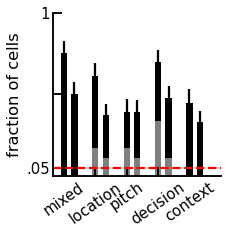

In [8]:
plt.figure(figsize=(3,3))

pure_idx = np.sum(ps<0.05,1) == 1
p_frac = ps<0.05
p_mixed = np.sum(p_frac[:,1:],1)>1 

for pop in [0,1]:
    pop_idx = pop_ids == (pop+1)
    all_p_frac = np.mean(p_frac[pop_idx],0)
    pure_p_frac = np.mean(p_frac[pop_idx & pure_idx],0)

    all_p_frac[0] = np.mean(p_mixed[pop_idx])
    pure_p_frac[0] = 0

    all_p_sterr = sts.sem(p_frac[pop_idx],0)
    all_p_sterr[0] = sts.sem(p_mixed[pop_idx])


    plt.bar(np.arange(5)*1.5+pop*0.5, all_p_frac,color='black',width=0.3)
    plt.bar(np.arange(5)*1.5+pop*0.5, pure_p_frac,color='gray',width=0.3)
    plt.errorbar(np.arange(5)*1.5+pop*0.5, all_p_frac,all_p_sterr , fmt=' ', color='k')


plt.xticks(np.arange(5)*1.5,["mixed","location","pitch","decision","context"],rotation=35)
plt.plot([-0.5,5*1.5],[0.05,0.05],"r--")
plt.xlim(-0.5,5*1.5)

plt.yticks([0.05,0.5,1],[".05","","1"])
plt.ylabel("fraction of cells")

sns.despine()
pop_idx = mean_pre_neuron.query('context == 1').population_id.values
mean_dif = [np.mean(neuron_dif[pop_idx==1]),np.mean(neuron_dif[pop_idx==2]),np.mean(neuron_dif[pop_idx==0])]
sem_dif = [sts.sem(neuron_dif[pop_idx==1]),sts.sem(neuron_dif[pop_idx==2]),sts.sem(neuron_dif[pop_idx==0])]
# plt.savefig("../Fig3_prestim_selectivity.svg")




In [10]:

random_diff_fr = []
diff_fr = []
for n, df_neuron in tqdm(df_A1.groupby('neuron_id')):
    fr_pre = df_neuron.groupby('context').mean().pre_stim.values
    diff_fr.append(fr_pre[0] - fr_pre[1])
    
    random_diff_neuron = []
    for _ in range(100):
        df_neuron['context'] = df_neuron['context'].sample(frac=1).values
        fr_pre = df_neuron.groupby('context').mean().pre_stim.values
        random_diff_neuron.append(fr_pre[0] - fr_pre[1])

    random_diff_fr.append(random_diff_neuron)

100%|██████████| 130/130 [00:20<00:00,  6.37it/s]


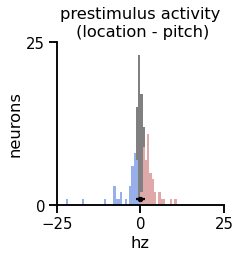

In [11]:
bins = np.linspace(-25,25,75)
shuff_percs = np.percentile(np.concatenate(random_diff_fr)/0.05,[2.5,97.5])


plt.figure(figsize=(3,3))
plt.hist(neuron_dif,bins=bins,color='gray')
plt.hist(neuron_dif[pop_idx==1],bins=bins,color='#98afea',label='location')
plt.hist(neuron_dif[pop_idx==2],bins=bins,color='#e0a9a9',label='pitch')

plt.errorbar(0,1, xerr=np.abs(np.array(shuff_percs)[:,None]), fmt='.',color='black')


plt.title('prestimulus activity\n (location - pitch)')
plt.xlabel('hz')
plt.ylabel('neurons')
plt.tick_params(direction="out", bottom=True, length=8)
plt.yticks([0,25])
plt.xticks([-25,0,25])
plt.xlim(-25,25)
plt.ylim(0,25)
sns.despine()


# plt.savefig("../Fig3_prestim_fr_hist.svg")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=af3700bb-635f-4f56-95cc-6d24931ab29c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>